## Submitted by: Durga V - I190308, MA Financial Economics 

### Import modules

For data loading and processing, we have mostly used made use of the pandas library
For machine learning models, we got sklearn-kit
and MatplotLib for plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import PartialDependenceDisplay
np.random.seed(0)
warnings.filterwarnings('ignore')


### Data Imports

1. Median List Price and Median Selling Price data is obtained from zillow.com and its cleant using a function

In [2]:
#clean the data and pre process
#For zillow data: it consists of all states, only the first row has the US statistics - we need just that
def clean_data_from_zillow(df, var_name):
    df = pd.DataFrame(df.loc[0,:].T).iloc[5:]
    df.columns = [var_name]
    df['month'] = pd.to_datetime(df.index)
    df = df.reset_index(drop=True)
    return df

mlp = pd.read_csv("Median list price (smooth, all homes, monthly).csv")
mlp = clean_data_from_zillow(df = mlp, var_name='MLP')
mlp['year_month'] = pd.to_datetime(mlp['month']).dt.strftime('%Y-%m')

msp = pd.read_csv("Median Sale Price (smooth, all homes, monthly).csv")
msp = clean_data_from_zillow(df = msp, var_name='MSP')
msp['year_month'] = pd.to_datetime(msp['month']).dt.strftime('%Y-%m')


2. Import the X variables: CPI, Effective Federal Funds Rate, Unemployment Rate and Real GDP from CSV files obtained from Federal Reserve Economic Data

In [3]:
cpi = pd.read_csv("cpi.csv")
cpi.columns = ['DATE','CPI']
cpi['cpi_percent'] = cpi['CPI']
cpi.drop(columns=['CPI'])
cpi['year_month'] = pd.to_datetime(cpi['DATE']).dt.strftime('%Y-%m')

effr = pd.read_csv('effr.csv')
effr.columns = ['DATE','IR']
effr['year_month'] = pd.to_datetime(effr['DATE']).dt.strftime('%Y-%m')

unemp_rate = pd.read_csv('unemp rate.csv')
unemp_rate['year_month'] = pd.to_datetime(unemp_rate['DATE']).dt.strftime('%Y-%m')

realgdp = pd.read_csv('realgdp.csv')
realgdp = realgdp.rename(columns={'GDPC1':"realGDP"})
realgdp['year_month'] = pd.to_datetime(realgdp['DATE']).dt.strftime('%Y-%m')

3. Merge all the dataframes into a single data for processing

In [4]:
def merge_dataframes(df_list, merge_column):
    if len(df_list) == 1:
        return df_list[0]
    elif len(df_list) == 2:
        return pd.merge(df_list[0], df_list[1], on=merge_column, how='left')
    else:
        return pd.merge(df_list[0], merge_dataframes(df_list[1:], merge_column), on=merge_column, how='left')


dataset = merge_dataframes([mlp,msp,cpi,effr,unemp_rate,realgdp],"year_month")
#clean it slightly
dataset.drop(columns=[col for col in dataset.columns if col.startswith("DATE_") or col.startswith('month_')], inplace=True)
dataset['year_month'] = pd.to_datetime(dataset['year_month'], format='%Y-%m').dt.strftime('%B %Y')
cols_order = ['year_month','MLP','MSP','cpi_percent','IR','UNRATE','realGDP']
dataset = dataset[cols_order]
dataset.columns = ['month_year','MLP','MSP','CPI','intRate','unempRate','realGDP']
dataset['month_year'] = pd.to_datetime(dataset['month_year'])


### The "dataset" before cleaning in its raw state

In [5]:
dataset

,month_year,MLP,MSP,CPI,intRate,unempRate,realGDP
0,2018-03-01,263267.0,227967.0,105.289494,1.51,4.0,NaN
1,2018-04-01,271267.0,231333.0,105.708029,1.69,4.0,18565.697
2,2018-05-01,276300.0,235667.0,106.147660,1.70,3.8,NaN
3,2018-06-01,279667.0,240667.0,106.316846,1.82,4.0,NaN
4,2018-07-01,279967.0,243667.0,106.324019,1.91,3.8,18699.748
5,2018-08-01,279633.0,243667.0,106.383086,1.91,3.8,NaN
6,2018-09-01,279600.0,239667.0,106.506706,1.95,3.7,NaN
7,2018-10-01,279467.0,235901.0,106.694878,2.19,3.8,18733.741
8,2018-11-01,279467.0,234201.0,106.337520,2.20,3.8,NaN
9,2018-12-01,277833.0,233534.0,105.997882,2.27,3.9,NaN


### Box plot of the data before processing: (Fig 1)

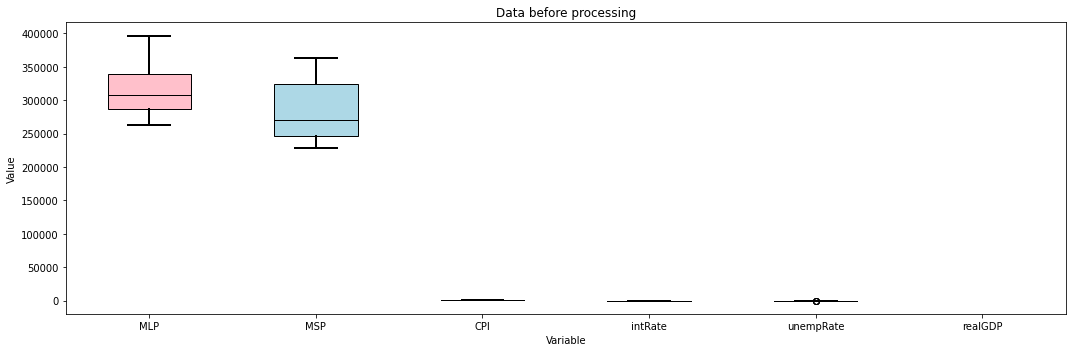

In [6]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 1, figsize=(15, 5),facecolor="white")
df_box = pd.melt(dataset, id_vars='month_year', value_vars=dataset.columns[1:])
bp = ax.boxplot([df_box[df_box['variable'] == col]['value'] for col in dataset.columns[1:]], labels=dataset.columns[1:], patch_artist=True)

# Change the color of the boxes
colors = ['pink', 'lightblue', 'yellow', 'lightgreen', 'salmon', 'violet']
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i % len(colors)])

# Change the color of the borders
for i, whisker in enumerate(bp['whiskers']):
    whisker.set_color('black')
    whisker.set_linewidth(2)

# Change the color and weight of the caps
for i, cap in enumerate(bp['caps']):
    cap.set_color('black')
    cap.set_linewidth(2)

# change median color
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(1)

ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Data before processing")

plt.tight_layout()
plt.show()


### Data cleaning: interpolation, outliers, filling NaNs with median

In [7]:
#Real GDP data is not available on a monthly basis, so interpolate it linearly
dataset["realGDP"].interpolate(method="linear", inplace=True)

#Replace all outliers falling outside the range of 1st and 3rd quartile with their respective median values
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cols_to_consider = ['MLP','MSP','CPI','intRate','unempRate','realGDP']
dataset = dataset[~((dataset[cols_to_consider] < lower_bound) | 
                     (dataset[cols_to_consider] > upper_bound)).any(axis=1)]

#Filling NaN values with the median
dataset.fillna(dataset.median(), inplace=True)

### The "dataset" after basic cleaning

In [8]:
dataset

,month_year,MLP,MSP,CPI,intRate,unempRate,realGDP
0,2018-03-01,263267.0,227967.0,105.289494,1.51,4.0,19159.185000
1,2018-04-01,271267.0,231333.0,105.708029,1.69,4.0,18565.697000
2,2018-05-01,276300.0,235667.0,106.147660,1.70,3.8,18610.380667
3,2018-06-01,279667.0,240667.0,106.316846,1.82,4.0,18655.064333
4,2018-07-01,279967.0,243667.0,106.324019,1.91,3.8,18699.748000
5,2018-08-01,279633.0,243667.0,106.383086,1.91,3.8,18711.079000
6,2018-09-01,279600.0,239667.0,106.506706,1.95,3.7,18722.410000
7,2018-10-01,279467.0,235901.0,106.694878,2.19,3.8,18733.741000
8,2018-11-01,279467.0,234201.0,106.337520,2.20,3.8,18767.631000
9,2018-12-01,277833.0,233534.0,105.997882,2.27,3.9,18801.521000


### Descriptive statistics 

In [9]:
dataset.describe()

,MLP,MSP,CPI,intRate,unempRate,realGDP
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,317735.074074,282565.000000,112.410237,1.257407,4.429630,19307.790611
std,38269.549910,43089.262322,6.448900,1.043076,1.241215,563.568759
min,263267.000000,227967.000000,105.289494,0.060000,3.500000,17915.767000
25%,286608.250000,243992.000000,107.875806,0.090000,3.600000,18867.477417
50%,309647.000000,280333.000000,109.793390,1.550000,3.800000,19159.185000
75%,339967.000000,324333.000000,116.455465,2.175000,4.725000,19902.475250
max,396667.000000,363333.000000,125.734441,3.780000,8.400000,20198.091000


### Finding average change per year in each variable over the timeframe 

In [10]:
def find_average_change_in_variables(column):
    change = (((dataset[column]-dataset[column].shift(1))/dataset[column].shift(1))*100).mean()
    return change

average_changes =[]
for i in dataset.columns[1:]:
    change = find_average_change_in_variables(i)
    average_changes.append({
        'Variable' : i,
        'Change' : change
    })
    
pd.DataFrame(average_changes)

,Variable,Change
0,MLP,0.711124
1,MSP,0.437908
2,CPI,0.096673
3,intRate,6.262979
4,unempRate,0.547409
5,realGDP,0.104830


In [11]:
for i in dataset.columns[1:]:
    latest = dataset.iloc[-1][i]
    latest_date = (dataset.iloc[-1]["month_year"]).strftime("%b %Y")
    starting_date = (dataset.iloc[0]["month_year"]).strftime("%b %Y")
    starting = dataset.iloc[0][i]
    change = round(((latest-starting)/starting)*100,2)
    print(f"{i}      \tincreased(decreased) by {change} % from \t{starting_date} to {latest_date}")

MLP      	increased(decreased) by 44.2 % from 	Mar 2018 to Dec 2022
MSP      	increased(decreased) by 22.97 % from 	Mar 2018 to Dec 2022
CPI      	increased(decreased) by 4.28 % from 	Mar 2018 to Dec 2022
intRate      	increased(decreased) by 2.65 % from 	Mar 2018 to Dec 2022
unempRate      	increased(decreased) by -5.0 % from 	Mar 2018 to Dec 2022
realGDP      	increased(decreased) by 5.42 % from 	Mar 2018 to Dec 2022


### Feature Scaling before model training 

In [12]:
#The Dataset before scaling for future use.
original_dataset = dataset.copy()

In [13]:
"""
Normalizing to reduce the risk of over-fitting
"""
columns_to_normalize = ['MLP', 'MSP','CPI', 'intRate', 'unempRate', 'realGDP']
scaler = StandardScaler()
dataset[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])

### The "dataset" after feature scaling 

In [14]:
dataset

,month_year,MLP,MSP,CPI,intRate,unempRate,realGDP
0,2018-03-01,-1.436639,-1.278988,-1.114547,0.244435,-0.349386,-0.266163
1,2018-04-01,-1.225632,-1.200138,-1.049038,0.418622,-0.349386,-1.329140
2,2018-05-01,-1.092883,-1.098612,-0.980226,0.428299,-0.512032,-1.249109
3,2018-06-01,-1.004076,-0.981484,-0.953745,0.544423,-0.349386,-1.169077
4,2018-07-01,-0.996163,-0.911207,-0.952622,0.631517,-0.512032,-1.089046
5,2018-08-01,-1.004973,-0.911207,-0.943377,0.631517,-0.512032,-1.068751
6,2018-09-01,-1.005843,-1.004909,-0.924028,0.670225,-0.593355,-1.048456
7,2018-10-01,-1.009351,-1.093130,-0.894575,0.902474,-0.512032,-1.028162
8,2018-11-01,-1.009351,-1.132954,-0.950509,0.912151,-0.512032,-0.967463
9,2018-12-01,-1.052449,-1.148578,-1.003670,0.979891,-0.430709,-0.906763


### Box plot of the data after all data pre-processing: fig 2 

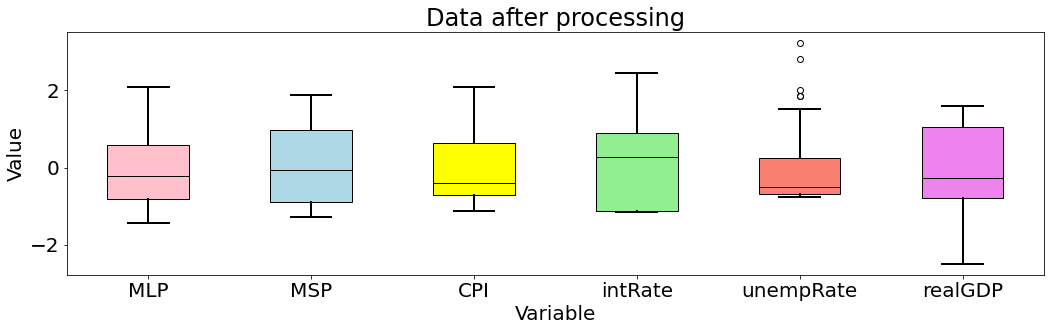

In [15]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 1, figsize=(15, 5),facecolor="white")
df_box = pd.melt(dataset, id_vars='month_year', value_vars=dataset.columns[1:])
bp = ax.boxplot([df_box[df_box['variable'] == col]['value'] for col in dataset.columns[1:]], labels=dataset.columns[1:], patch_artist=True)

# Change the color of the boxes
colors = ['pink', 'lightblue', 'yellow', 'lightgreen', 'salmon', 'violet']
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i % len(colors)])

# Change the color of the borders
for i, whisker in enumerate(bp['whiskers']):
    whisker.set_color('black')
    whisker.set_linewidth(2)

# Change the color and weight of the caps
for i, cap in enumerate(bp['caps']):
    cap.set_color('black')
    cap.set_linewidth(2)

# change median color
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(1)

ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Data after processing")

plt.tight_layout()
plt.show()


### Time series of MLP and features 

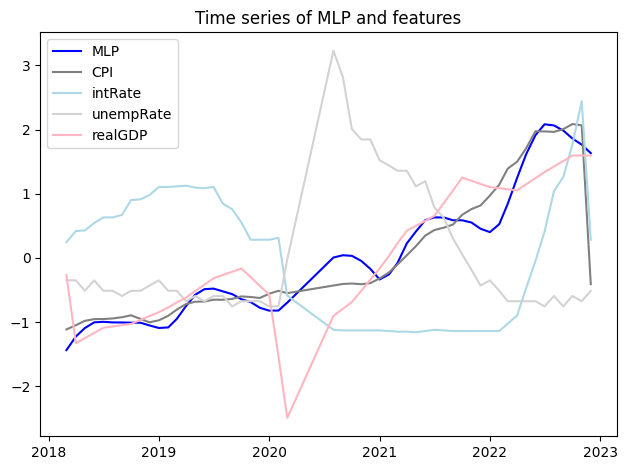

In [16]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 10,'figure.facecolor':"white"})
color_list = ['blue', 'grey', 'lightblue', 'lightgrey', 'lightpink']
for i, col in enumerate(['MLP', 'CPI', 'intRate', 'unempRate', 'realGDP']):
    plt.plot(dataset['month_year'], dataset[col], color=color_list[i], label=col)
plt.title("Time series of MLP and features")
plt.legend()
plt.tight_layout()

### Time series of MSP and features 

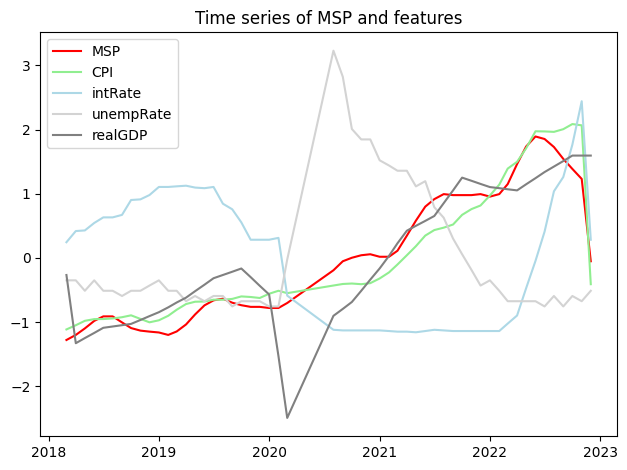

In [17]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 10,'figure.facecolor':"white"})
color_list = ['red', 'lightgreen', 'lightblue', 'lightgrey', 'grey']
for i, col in enumerate(['MSP', 'CPI', 'intRate', 'unempRate', 'realGDP']):
    plt.plot(dataset['month_year'], dataset[col], color=color_list[i], label=col)
plt.title("Time series of MSP and features")
plt.legend()
plt.tight_layout()


### Splitting the dataset into training and testing sets in 80-20 ratio

In [18]:
X = dataset.drop(['MLP', 'MSP','month_year'], axis=1) # Features
y_mlp = dataset['MLP'] # Target for MLP
y_msp = dataset['MSP'] # Target for MSP

X_train, X_test, y_train_mlp, y_test_mlp = train_test_split(X, y_mlp, test_size=0.2, random_state=0)
X_train, X_test, y_train_msp, y_test_msp = train_test_split(X, y_msp, test_size=0.2, random_state=0)


### Model selection using iteration 
#### [ briefly explained in the IV. Methodology under part (c) Model selection ]

In [19]:
"""
DISCLAIMER: This part of the code gives different output each time it's run due to the dynamicity and initialization state.
So, so the average scores are considered each time.
"""
# Define a list of models
models = [DecisionTreeRegressor(random_state=0), RandomForestRegressor(), 
          KNeighborsRegressor(), GradientBoostingRegressor(random_state=0)]
mlp_eval = []
msp_eval = []

for model in (models):
    mses = []
    r2s = []
    for i in range(0,2):
        model.fit(X_train, y_train_mlp)
        y_pred_mlp = model.predict(X_test)
        mse = round(mean_squared_error(y_test_mlp, y_pred_mlp),2)
        r2 = round(r2_score(y_test_mlp, y_pred_mlp),2)
        mses.append(mse)
        r2s.append(r2)
    mlp_eval.append({
        'model' : model.__class__.__name__,
        'mse' : np.array(mses).mean(),
        'r2 score' : np.array(r2s).mean()
    })

for model in (models):
    mses = []
    r2s = []
    for i in range(0,5):
        model.fit(X_train, y_train_msp)
        y_pred_msp = model.predict(X_test)
        mse = round(mean_squared_error(y_test_msp, y_pred_msp),2)
        r2 = round(r2_score(y_test_msp, y_pred_msp),2)
        mses.append(mse)
        r2s.append(r2)
    msp_eval.append({
        'model' : model.__class__.__name__,
        'mse' : np.array(mses).mean(),
        'r2 score' : np.array(r2s).mean()
    })

mlp_eval = pd.DataFrame(mlp_eval)
mlp_eval['weight_score'] = [((i*0.7)+((1-0.7)*j)) for i,j in zip(mlp_eval['mse'],mlp_eval['r2 score'])]
print("Results for MLP")
display(mlp_eval)

msp_eval = pd.DataFrame(msp_eval)
msp_eval['weight_score'] = [((i*0.55)+((1-0.55)*j)) for i,j in zip(msp_eval['mse'],msp_eval['r2 score'])]
print("Results for MSP")
display(msp_eval)

Results for MLP


,model,mse,r2 score,weight_score
0,DecisionTreeRegressor,0.52,0.52,0.520
1,RandomForestRegressor,0.15,0.86,0.363
2,KNeighborsRegressor,0.34,0.69,0.445
3,GradientBoostingRegressor,0.21,0.80,0.387


Results for MSP


,model,mse,r2 score,weight_score
0,DecisionTreeRegressor,0.10,0.890,0.4555
1,RandomForestRegressor,0.05,0.944,0.4523
2,KNeighborsRegressor,0.04,0.960,0.4540
3,GradientBoostingRegressor,0.02,0.980,0.4520


#### The best model for MLP is RandomForestRegressor with the least weighted score of 0.3665
#### The best model for MSP is GradientBoostingRegressor with the least weighted score of 0.4520

### Finding optimal params: n_estimators - the number of trees in the node 

In [20]:
def find_best_n_estimators(X_train, y_train, model):
    # define the parameter grid to search over
    param_grid = {'n_estimators': np.arange(10, 100, 10)}

    # create a RandomForestRegressor object
    rfr = model()

    # create a GridSearchCV object to search over the parameter grid
    grid_search = GridSearchCV(rfr, param_grid, cv=5)

    # fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # get the best value for n_estimators
    best_n_estimators = grid_search.best_params_['n_estimators']
    return best_n_estimators


### Training and fitting the data into the selected model

In [21]:
mlp_estimators = find_best_n_estimators(X_train=X_train,y_train=y_train_mlp, model=RandomForestRegressor)
print("Optimal n_estimators for MLP: ", mlp_estimators)
print("Training the model for MSP . . .")

mlp_model = RandomForestRegressor(n_estimators=mlp_estimators)
mlp_model.fit(X_train, y_train_mlp)

print("\n----------\n")

msp_estimators = find_best_n_estimators(X_train=X_train,y_train=y_train_msp, model=GradientBoostingRegressor)
print("Optimal n_estimators for MSP: ", msp_estimators)
print("Training the model for MSP . . .")
msp_model = GradientBoostingRegressor(n_estimators=msp_estimators)
msp_model.fit(X_train, y_train_msp)

Optimal n_estimators for MLP:  80
Training the model for MSP . . .

----------

Optimal n_estimators for MSP:  90
Training the model for MSP . . .


GradientBoostingRegressor(n_estimators=90)

### Testing the Model by making predictions on the test data 

In [22]:
y_pred_mlp = mlp_model.predict(X_test)
y_pred_msp = msp_model.predict(X_test)

### Evaluating the test data predictions using Mean Square Error and R^2 scores 

In [23]:
# Median List Price
mse_mlp = round(mean_squared_error(y_test_mlp, y_pred_mlp),2)
r2_mlp = round(r2_score(y_test_mlp, y_pred_mlp),2)

# Median Selling Price
mse_msp = round(mean_squared_error(y_test_msp, y_pred_msp),2)
r2_msp = round(r2_score(y_test_msp, y_pred_msp),2)

print("Mean Squared Error (Median List Price):", mse_mlp)
print("R2 Score (Median List Price):", r2_mlp)
print("Mean Squared Error (Median Selling Price):", mse_msp)
print("R2 Score (Median Selling Price):", r2_msp)


Mean Squared Error (Median List Price): 0.15
R2 Score (Median List Price): 0.86
Mean Squared Error (Median Selling Price): 0.03
R2 Score (Median Selling Price): 0.97


### Actual vs Predictions Plotting: Fig 4 & Fig 7

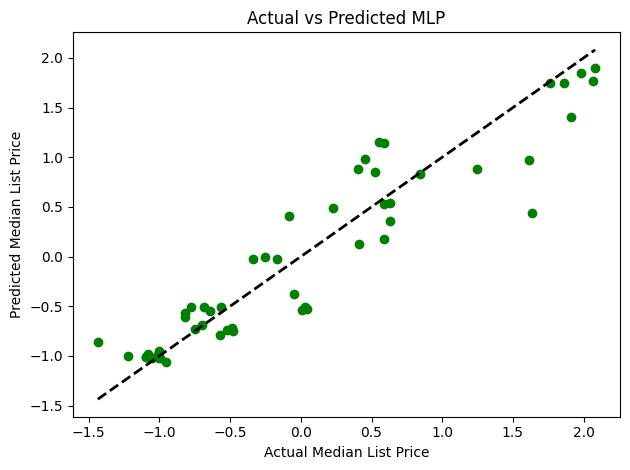

In [24]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 10,'figure.facecolor':"white"})
y_pred_mlp_cv = cross_val_predict(mlp_model, X, y_mlp, cv=10)
plt.scatter(y_mlp, y_pred_mlp_cv, color='green')
plt.plot([y_mlp.min(), y_mlp.max()], [y_mlp.min(), y_mlp.max()], 'k--', lw=2, color="black")
plt.xlabel('Actual Median List Price')
plt.ylabel('Predicted Median List Price')
plt.title("Actual vs Predicted MLP")
plt.tight_layout()
plt.show()

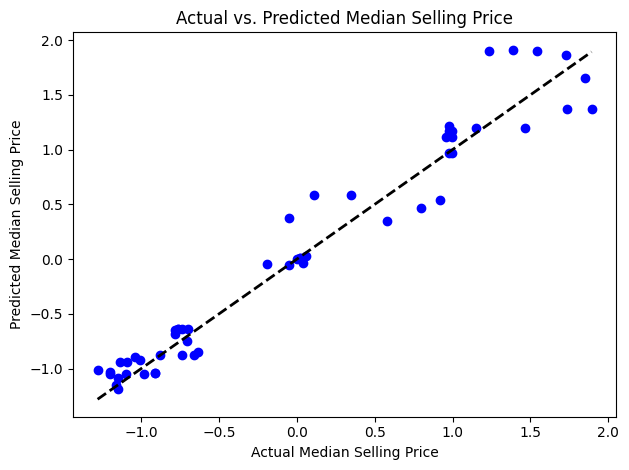

In [25]:
plt.rcdefaults()

plt.rcParams.update({'font.size': 10,'figure.facecolor':"white"})

y_pred_msp_cv = cross_val_predict(msp_model, X, y_msp, cv=10)


plt.scatter(y_msp, y_pred_msp_cv, color='blue')
plt.plot([y_msp.min(), y_msp.max()], [y_msp.min(), y_msp.max()], 'k--', lw=2)
plt.xlabel('Actual Median Selling Price')
plt.ylabel('Predicted Median Selling Price')
plt.title('Actual vs. Predicted Median Selling Price')
plt.tight_layout()
plt.show()



### Residual plots: Fig 5 & Fig 9

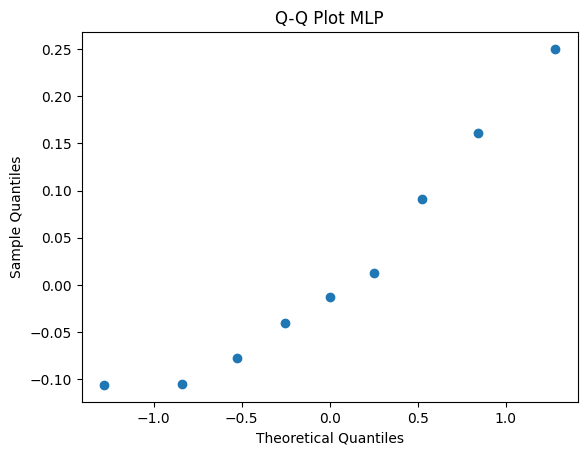

In [26]:
residuals = y_test_mlp - y_pred_mlp #calculating residuals
# Calculate the theoretical normal quantiles
theoretical_quantiles = stats.norm.ppf(np.linspace(0, 1, len(residuals)))
# Create the Q-Q plot
plt.scatter(theoretical_quantiles, sorted(residuals))
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("Q-Q Plot MLP")
plt.show()

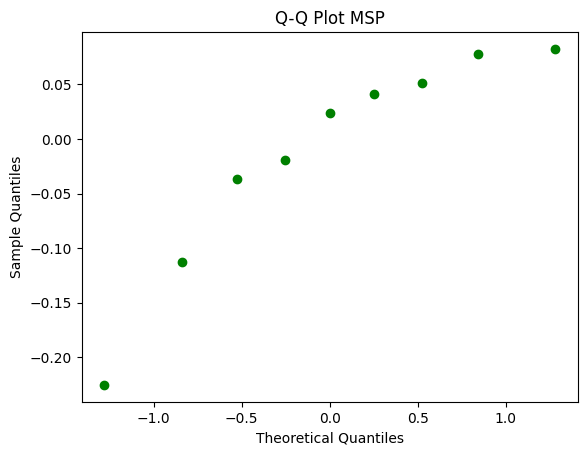

In [27]:
residuals = y_test_msp - y_pred_msp #calculating residuals
# Calculate the theoretical normal quantiles
theoretical_quantiles = stats.norm.ppf(np.linspace(0, 1, len(residuals)))
# Create the Q-Q plot
plt.scatter(theoretical_quantiles, sorted(residuals), color="green")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("Q-Q Plot MSP")
plt.show()

### Variable importance/weights in each model: Fig 6 & Fig 10 

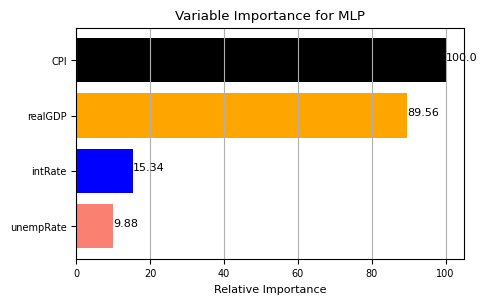

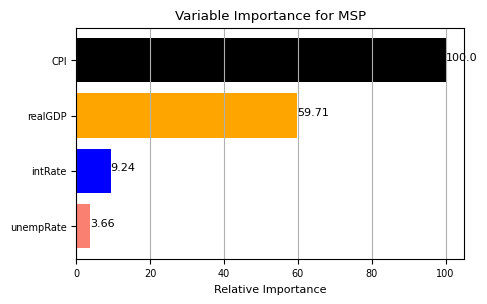

In [28]:

def plot_importance(model, feature_names, model_type):
    plt.rcParams.update({'font.size': 8,'figure.facecolor':"white"})
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(5,3))
    colors = ['salmon', 'blue', 'orange', 'black']
    for i, (importance, feature) in enumerate(zip(feature_importance[sorted_idx], [feature_names[j] for j in sorted_idx])):
        plt.barh(i + 0.5, importance, align='center', color=colors[i % len(colors)])
        plt.text(round(importance,2), round(i + 0.5,2), str(round(importance,2)))
    plt.yticks(pos, [feature_names[i] for i in sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for ' + model_type)
    # Make the x-axis labels more readable
    plt.gca().xaxis.grid(True)
    plt.gca().xaxis.set_tick_params(labelsize=7)
    plt.gca().yaxis.set_tick_params(labelsize=7)
    plt.show()


plot_importance(mlp_model, X_train.columns, "MLP")
plot_importance(msp_model, X_train.columns, "MSP")




In [64]:
def denormalize_variables(variables, col):
    y_std = original_dataset[col].std()
    y_mean = original_dataset[col].mean()
    denormalized = variables * y_std + y_mean
    return denormalized 

def normalize_variables(variables, col):
    y_std = original_dataset[col].std()
    y_mean = original_dataset[col].mean()
    normalized = (variables - y_mean)/y_std 
    return normalized 

def make_predictions():
    intRate = input("Interest Rate: ")
    unempRate = input("Unemployment Rate: ")
    realGDP = input("Real GDP: ")
    CPI = input("CPI: ")
    data = {
        'CPI' : normalize_variables(float(CPI),col="CPI"),
        'intRate': normalize_variables(float(intRate),col="intRate"),
        'unempRate':normalize_variables(float(unempRate),col="unempRate"),
        'realGDP' : normalize_variables(float(realGDP),col="realGDP"),
    }
    data = pd.DataFrame(data,index=[0])
    mlp_pred = denormalize_variables(mlp_model.predict((data)),"MLP")
    msp_pred = denormalize_variables(msp_model.predict((data)),"MSP")
    print("Predicted MLP: ", round(mlp_pred[0],2))
    print("Predicted MSP: ", round(msp_pred[0]),2)
    return

# BONUS

# Make predictions using the model 

In [65]:
make_predictions()

Interest Rate: 4
Unemployment Rate: 4
Real GDP: 20000
CPI: 120
Predicted MLP:  358228.09
Predicted MSP:  336984 2
